In [1]:
import numpy as np
import lbg_forecast.nz as nz
import lbg_forecast.population_model as pop
import lbg_forecast.nz as nz
import matplotlib.pyplot as plt
import lbg_forecast.sfh as sfh
import lbg_forecast.priors_gp_dust as gpdp
import scipy as sc

In [2]:
import sys
buf = np.zeros((120, 1000000, 17))
sys.getsizeof(buf)*1e-9

16.320000144

In [3]:
spsp = np.load("sps_parameter_samples/sps_test.npy")
photometry = np.load("photo_samples/photo_test.npy")
nzs = np.load("nz_samples/nz_test.npy", allow_pickle=True)

print(spsp.shape, nzs.shape)

(8, 100000, 17) (8, 3)


In [4]:
#spsp = np.load("sps_parameter_samples/sps_2.npy")
#nzs = np.load("nz_samples/nz_2.npy", allow_pickle=True)
#print(spsp.shape,  nzs.shape)

TypeError: len() of unsized object

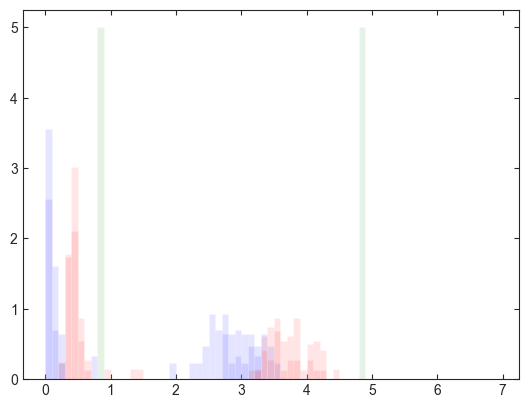

In [5]:
bins = nz.default_nz_bins()

for n in range(nzs.shape[0]):
    hist = plt.hist(nzs[n][0], density=True, bins=bins, alpha = 0.1, color='blue')
    hist = plt.hist(nzs[n][1], density=True, bins=bins, alpha = 0.1, color='red')
    hist = plt.hist(nzs[n][2], density=True, bins=bins, alpha = 0.1, color='green')

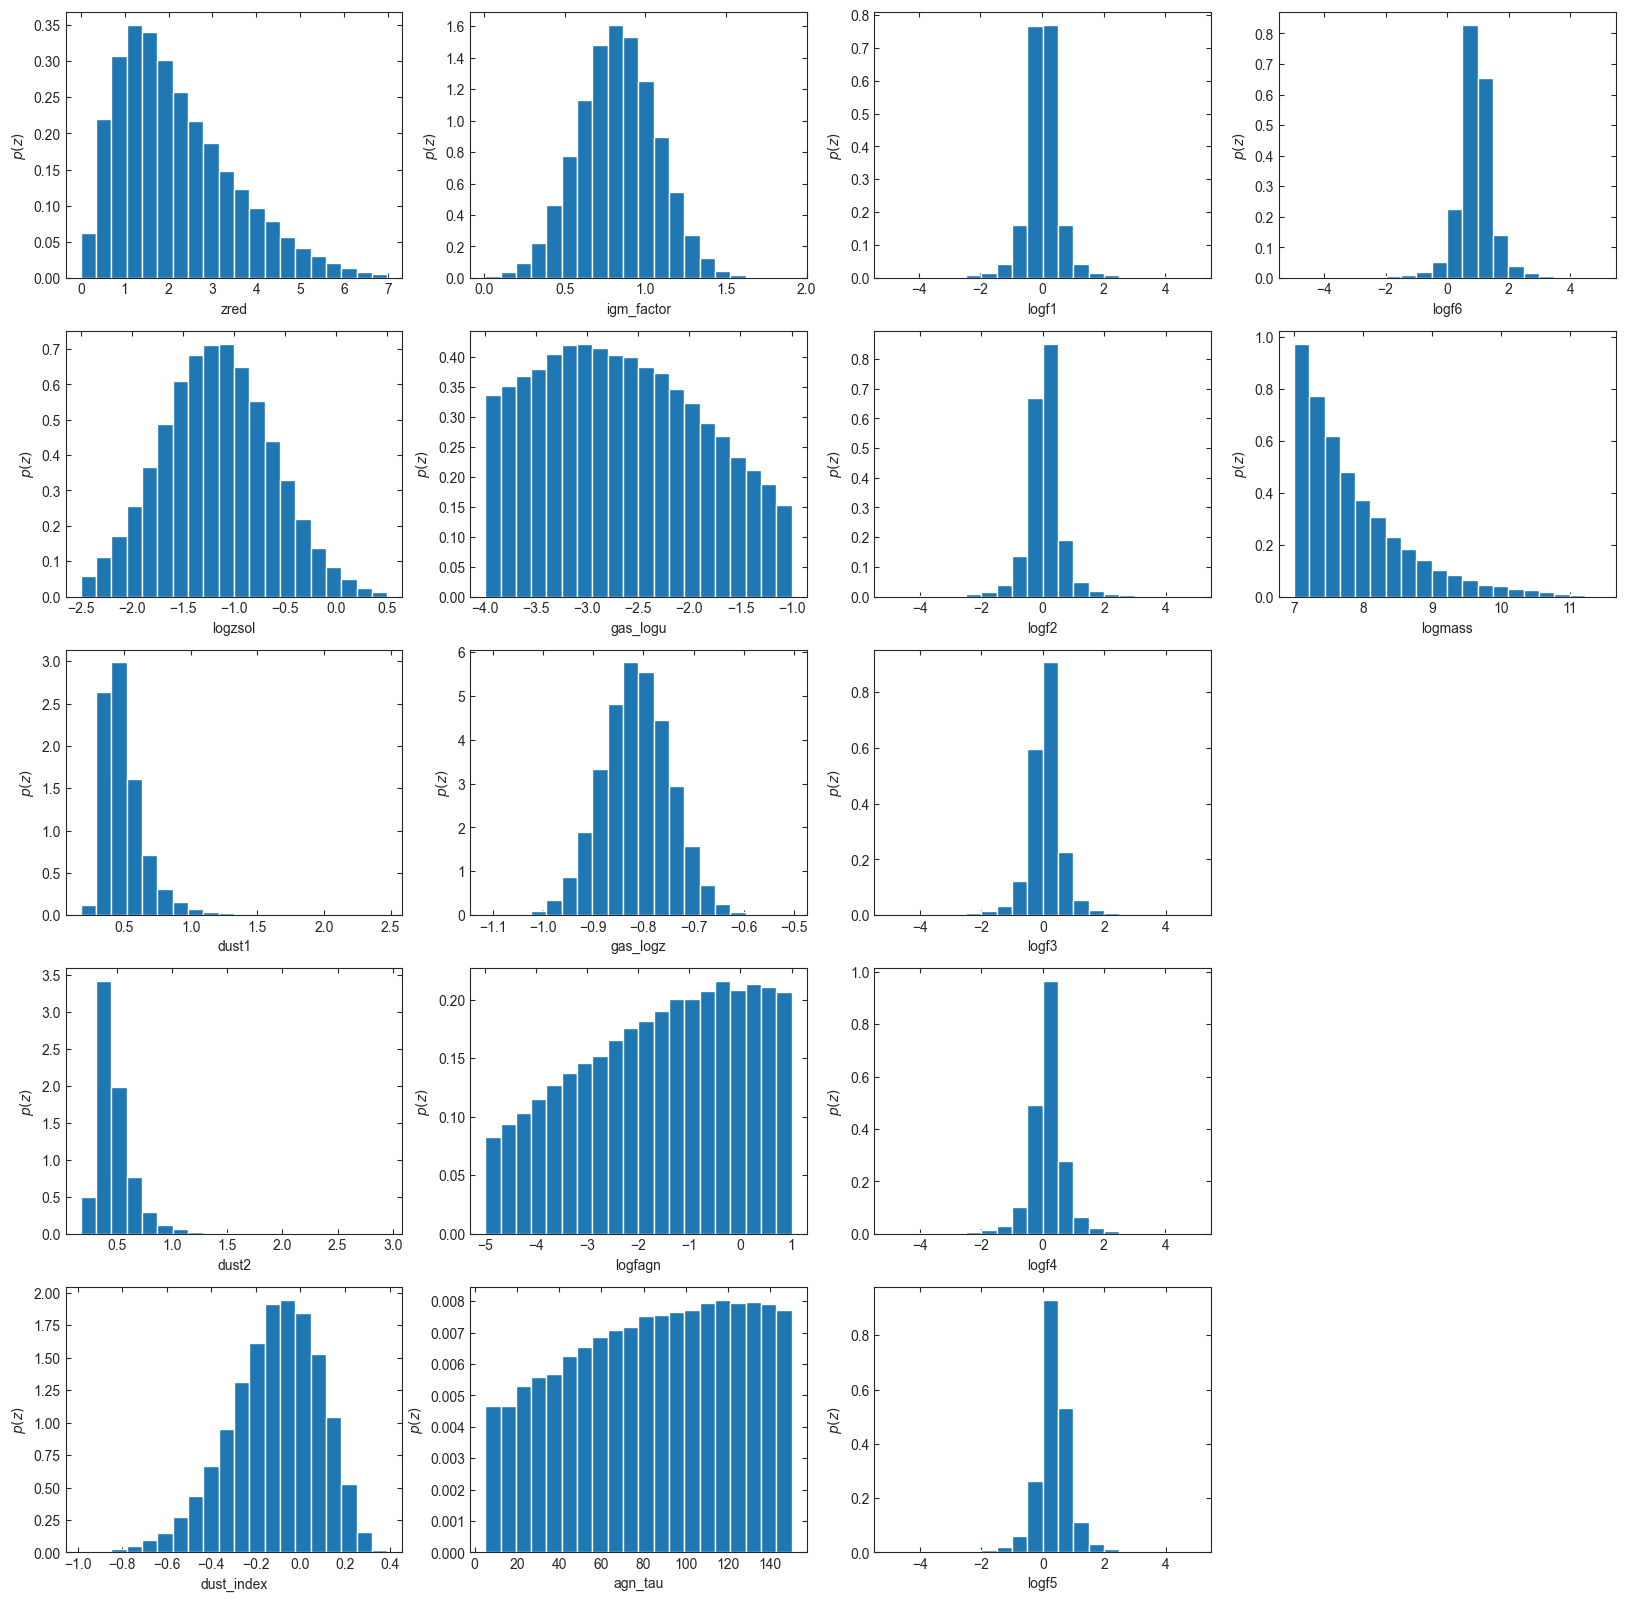

In [ ]:
indx=np.random.randint(0, nzs.shape[0])
pop.plot_galaxy_population(spsp[indx])

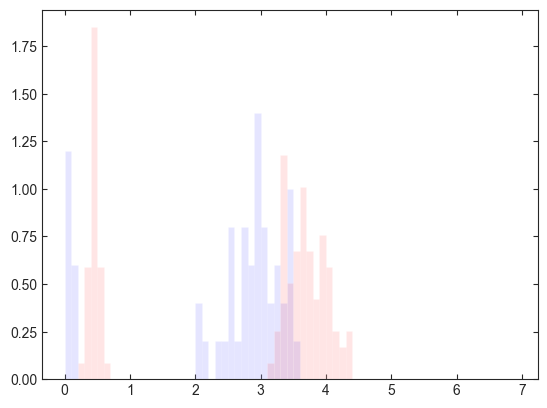

In [ ]:
indx=np.random.randint(0, nzs.shape[0])
hist = plt.hist(nzs[indx][0], density=True, bins=bins, alpha = 0.1, color='blue')
hist = plt.hist(nzs[indx][1], density=True, bins=bins, alpha = 0.1, color='red')
hist = plt.hist(nzs[indx][2], density=True, bins=bins, alpha = 0.1, color='green')

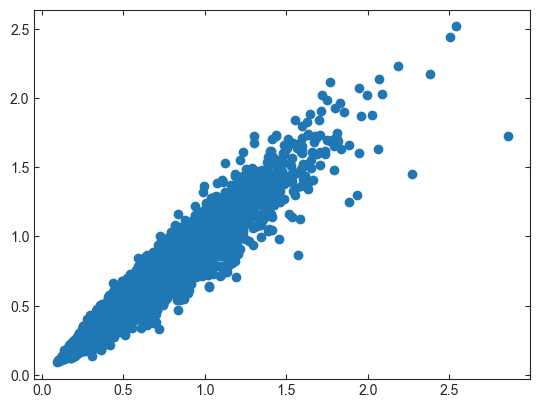

In [ ]:
indx=2
plt.scatter(spsp[indx][:, 3], spsp[indx][:, 2])

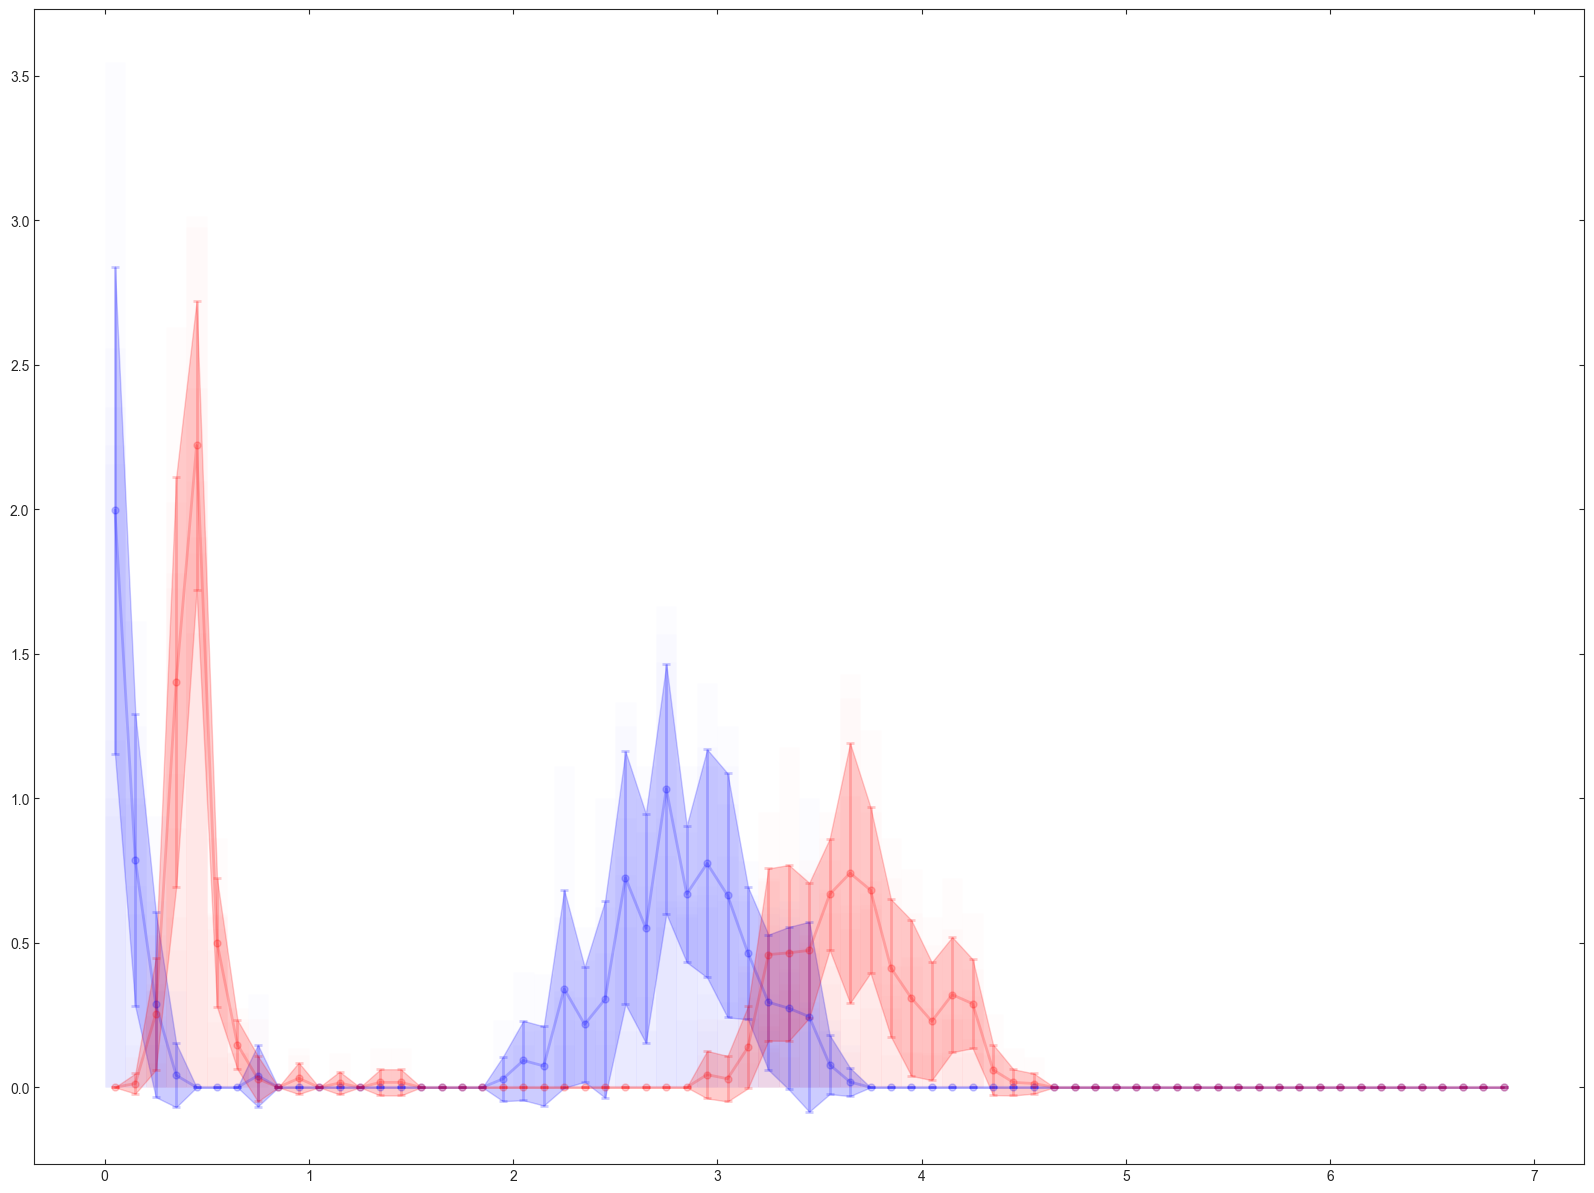

In [ ]:
fig1, axes = plt.subplots(1, 1, figsize=(20,15), sharex=False, sharey=False)

colours = ['blue', 'red', 'green']
for drop in range(3):

    values = []
    x = []
    for n in range(nzs.shape[0]):
        hist = axes.hist(nzs[n][drop], density=True, bins=bins, alpha = 0.01, color=colours[drop])
        values.append(hist[0])
        x.append(hist[1])

    values = np.hstack((np.array(values)))
    x = np.array(x)
    x = np.hstack(((x+0.05)[:,:-1]))


    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'mean', bins=bins)
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'std', bins=bins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axes.errorbar(bin_centers, bin_means, bin_std, alpha=0.2, ms=10, marker=".", elinewidth=2, capsize=3, capthick=2, lw=2, color=colours[drop])
    axes.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2, color=colours[drop])

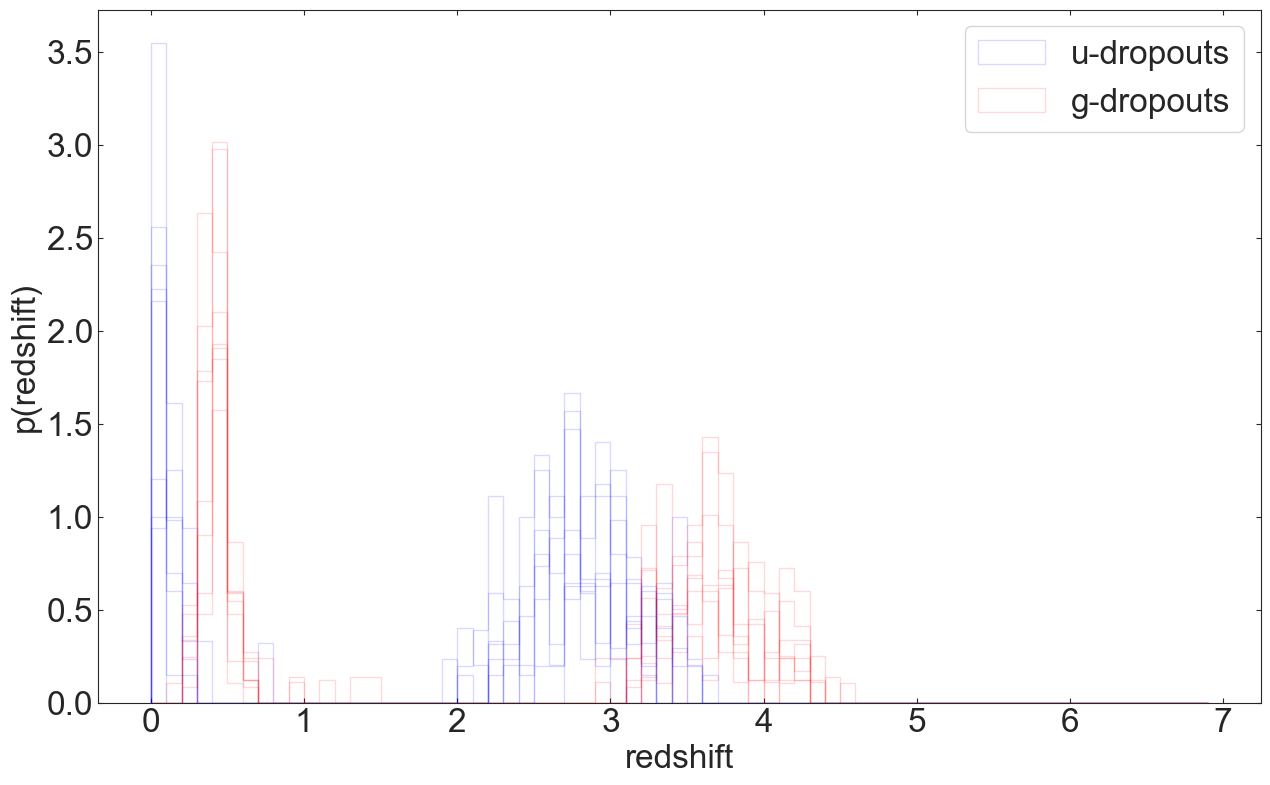

In [ ]:
colours = ['blue', 'red', 'green']
labels = ['u-dropouts', "g-dropouts", "r-dropouts"]
ndropouts=2
f, ax = plt.subplots(1, 1, figsize=(15, 9))
for ind in range(nzs.shape[0]):
    for drop in range(ndropouts):
        if(ind == 0):
            hist = plt.hist(nzs[ind][drop], density=True, bins=nz.default_nz_bins(), alpha = 0.15, color=colours[drop], histtype='step', label=labels[drop])
        else:
            hist = plt.hist(nzs[ind][drop], density=True, bins=nz.default_nz_bins(), alpha = 0.15, color=colours[drop], histtype='step')
plt.legend(fontsize=24)
plt.xlabel("redshift", fontsize=24)
plt.ylabel("p(redshift)", fontsize=24)
plt.tick_params('x', labelsize=24)
plt.tick_params('y', labelsize=24)

(0.0, 2.5)

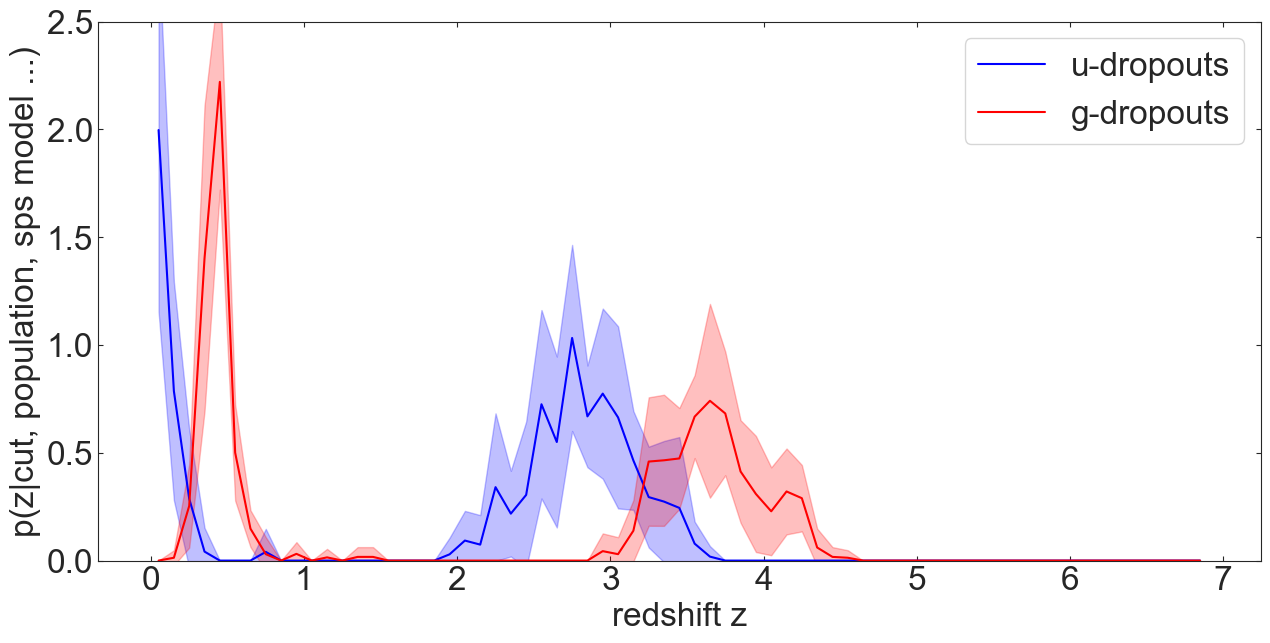

In [ ]:
fig1, axes = plt.subplots(1, 1, figsize=(15,7), sharex=False, sharey=False)

for drop in range(ndropouts):

    values = []
    x = []
    for ind in range(nzs.shape[0]):
        hist = axes.hist(nzs[ind][drop], density=True, bins=nz.default_nz_bins(), alpha = 0.001, color=colours[drop])
        values.append(hist[0])
        x.append(hist[1])

    values = np.hstack((np.array(values)))
    x = np.array(x)
    x = np.hstack(((x+0.05)[:,:-1]))


    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'mean', bins=nz.default_nz_bins())
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'std', bins=nz.default_nz_bins())
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    #axes.errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=10, fmt="o", elinewidth=2, capsize=3, capthick=2, lw=2, color=colours[drop], label=labels[drop])
    axes.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.25, color=colours[drop])
    axes.plot(bin_centers, bin_means, color=colours[drop], label=labels[drop])

plt.legend(fontsize=24)
plt.xlabel("redshift z", fontsize=24)
plt.ylabel("p(z|cut, population, sps model ...)", fontsize=24)
plt.tick_params('x', labelsize=24)
plt.tick_params('y', labelsize=24)
plt.ylim(0, 2.5)

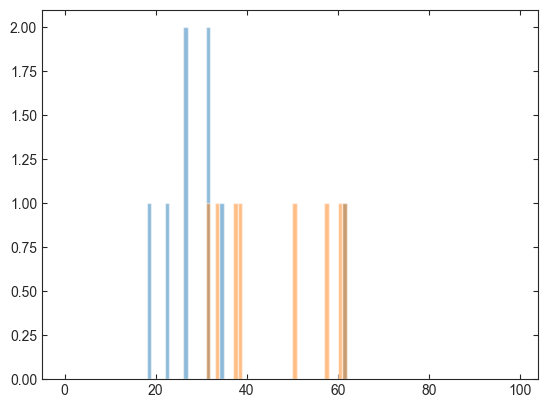

In [ ]:
def interlopers(samples):
    nint = len(np.where(samples<1.5)[0])
    ntot = len(samples)
    return (nint/ntot)*100

uints = []
gints = []
rints = []
for n in range(nzs.shape[0]):
    uints.append(interlopers(nzs[n][0]))
    gints.append(interlopers(nzs[n][1]))
    rints.append(interlopers(nzs[n][2]))

nbins = np.arange(0.0, 100, 1)
histogram = plt.hist(uints, alpha=0.5, bins=nbins)
histogram = plt.hist(gints, alpha=0.5, bins=nbins)
histogram = plt.hist(rints, alpha=0.5, bins=nbins)

(-12.0, -8.0)

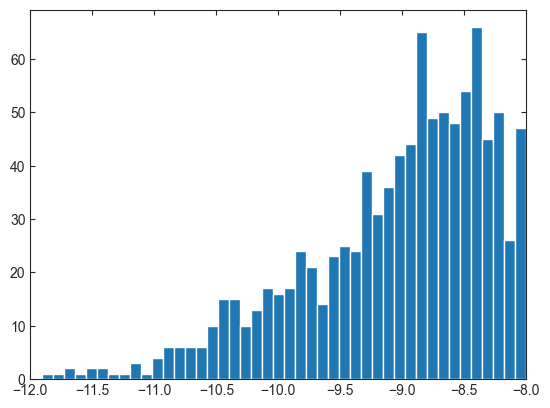

In [ ]:
import lbg_forecast.sfh as sfh
indx=np.random.randint(0, nzs.shape[0])
nsample = 1000
recent_sfrs = np.log10(sfh.calculate_recent_sfr(spsp[indx][:nsample, 0], spsp[indx][:nsample, -1], spsp[indx][:nsample, 10:-1])/spsp[indx][:nsample, -1])
plt.hist(recent_sfrs, bins=70)
plt.xlim(-12, -8)

In [ ]:
#np.save("nzs_test4.npy", nzs)
#np.save("spsp_test4.npy", spsp)